### **`05-Datos_aumentados 02: modelos-CNN`**
### **PROYECTO: DETECCIÓN HISTOPATOLÓGICA DEL CANCER**
### Fundamentos de Deep Learning - 2023-2

$ \mathcal{Daniel ~H. ~Martínez ~S. ~-~ UdeA} $ \
dhumberto.martinez@udea.edu.co
$ $

**Descripción del notebook:**

Con el objetivo de intentar disminuir el *overfiting* se realiza un procedimiento similar al `04- Modelos & Datos_aumentados -CNN`, pero aumentando los datos de entrenamiento solo realizando el wp a las muestras que no tienen células cancerígenas (`clase 0`).

In [1]:
# Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
from time import time
import os

from skimage import io
from pathlib import Path
from humanize import naturalsize
import tensorflow as tf
from tensorflow import keras
from tqdm.auto import tqdm
import h5py

import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
# Definitions
def load_data():
    !wget https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c0_00.h5
    !wget https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c0_01.h5
    !wget https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c0_02.h5
    !wget https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c1_00.h5
    !wget https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c1_01.h5
    !wget https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c1_02.h5

    # Padding region central
    !wget https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c0_mod_00.h5
    !wget https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c0_mod_01.h5
    !wget https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c0_mod_02.h5
    !wget https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c1_mod_00.h5
    !wget https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c1_mod_01.h5
    !wget https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c1_mod_02.h5

    path_train_labels ='https://raw.githubusercontent.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/main/data/'
    train_hc = []
    train_hc_cen = []
    for j in range(2):
      for i in range(3):
        file = 'H_c'+str(j)+'_0'+str(i)+'.h5'
        file2 = 'H_c'+str(j)+'_mod_0'+str(i)+'.h5'
        with h5py.File('/content/'+file,'r') as f:
          train_hc.append(f['train_img'][:])

        if j==0:
          with h5py.File('/content/'+file2,'r') as ff:
            train_hc_cen.append(ff['train_img'][:])

    train_hc = np.r_[train_hc].reshape(int(6*900), 96, 96, 3)
    train_hc_cen = np.r_[train_hc_cen].reshape(int(3*900), 96, 96, 3)
    train_labels = pd.read_csv(path_train_labels+'train_labels.csv')
    return train_hc,train_hc_cen, train_labels

def Norm_img(img):
    # Normalización min-max
    return (img-np.min(img))/(np.max(img)-np.min(img))

def show_mosaic_class(train_labels,class_h,num_rand =5):
    # Mostrar mosaico para un rand dado
    num_class = len(class_h)
    for j in class_h:
      img_rand = np.random.choice(train_labels['id'][train_labels['label'] == j],num_rand)
      fig = plt.figure(figsize=(12,14))
      for i,k in enumerate(img_rand):
        ax = fig.add_subplot(num_class, num_rand, i+1)
        img = io.imread(k+'.tif')
        ax.imshow(Norm_img(img))
        if i == 0:
          ax.set(title = 'CLASS: '+str(j))

def show_mosaic_id(dataset,class_h,num_rand =5):
    # Mostrar mosaico para un rand dado
    num_class = len(class_h)
    for j in class_h:
      img_rand = np.random.choice(np.arange(int(3*900)),num_rand)
      fig = plt.figure(figsize=(12,14))
      for i,k in enumerate(img_rand):
        ax = fig.add_subplot(num_class, num_rand, i+1)
        if j == 0:
          img = dataset[k]
        elif j == 1:
          img = dataset[k+int(3*900)]
        ax.imshow(Norm_img(img))
        if i == 0:
          ax.set(title = 'CLASS: '+str(j))

def show_mosaic_id_v2(dataset,class_h,num_rand =5):
    # Mostrar mosaico para un rand dado
    # num_class = len(class_h)
    # for j in class_h:

    img_rand = np.random.choice(np.arange(int(3*900)),num_rand)
    fig = plt.figure(figsize=(12,14))
    for i,k in enumerate(img_rand):
      ax = fig.add_subplot(1, num_rand, i+1)
      # if j == 0:
      img = dataset[k]
      # elif j == 1:
      #   img = dataset[k+int(3*900)]
      ax.imshow(Norm_img(img))
      # if i == 0:
      ax.set(title = 'CLASS: 0')

def rand_img(train_labels,class_h_,choose_ran = 'si',id='',show_plot = 'si'):
    if choose_ran == 'si':
      img_ = np.random.choice(train_labels['id'][train_labels['label'] == class_h_],1)
      img = io.imread(img_[0]+'.tif')
    elif choose_ran == 'no':
      img = io.imread(id+'.tif')
    if show_plot == 'si':
      fig, ax = plt.subplots(figsize = (5,4))
      ax.imshow(Norm_img(img))
      ax.set(title = 'CLASS: '+str(class_h_))
    plt.show()
    return img

def choose_img(train_labels,id,show_plot = 'si'):
    # Esoger imagen aleatoria para un clases dada
    img = io.imread(id+'.tif')
    if show_plot == 'si':
      fig, ax = plt.subplots(figsize = (5,4))
      ax.imshow(Norm_img(img))
      class_h_ = train_labels['label'][train_labels['id'] == id]
      class_h_ = class_h_.reset_index()
      print(class_h_)
      ax.set(title = 'Index: '+str(class_h_['index'].iloc[0])+' :--: CLASS: '+str(class_h_['label'].iloc[0]))
    plt.show();
    return img

def h5_w(path,N_img,data_ran):
    # Guardar archivo en formaro h5
    train_shape = (N_img,96,96,3)
    hf = h5py.File(path,'w')                            # Open a hdf5 file and create earrays
    hf.create_dataset('train_img',train_shape,np.uint8) #,compression="gzip", compression_opts=9)    # The pixels range is 0-255, dtype is uint
    for i,k in tqdm(enumerate(data_ran)):
      hf['train_img'][i,...] = choose_img(k, show_plot='no')
    hf.close()

def choose_img_label(h,choose_ran = 'si',show_plot = 'si',img_id=''):
    # Escoger imagen para un id dado o random
    if choose_ran == 'si':
      img_id = np.random.choice(np.arange(len(h)),1)[0]
      img = h[img_id]
    elif choose_ran == 'no':
      img = h[img_id]
    if show_plot == 'si':
      fig, ax = plt.subplots(figsize = (4,4))
      ax.imshow(Norm_img(img))
      if img_id < int(len(h)/2):
        class_h_ = 0
      else:
        class_h_ = 1
      ax.set(title = 'New index: '+str(img_id)+' :--: CLASS: '+str(class_h_))
    plt.show();
    return img

def train_val_test(train_hc,test_size=.2,show_val = 'no'):
    # Asignación de clases para los datos cargados
    class_aux =[]
    for j in class_h:
      class_aux.append(j*np.ones(int(len(train_hc)/2)).astype(int))
    class_aux = np.array(class_aux).reshape(1,len(train_hc))
    x_train_ori, x_test, y_train, y_test = train_test_split(train_hc, class_aux[0], test_size=test_size)
    x_train, x_val, y_train, y_val = train_test_split(x_train_ori, y_train, test_size=test_size)
    if show_val == 'si':
        print ('x_train, y_train:',x_train.shape, y_train.shape)
        print ('x_test, y_test:',x_test.shape, y_test.shape)
        print ('x_val, y_val:',x_val.shape, y_val.shape)
        print ("\n * Distribución de clases de train: ")
        print (pd.Series(y_train).value_counts())
        print ("\n * Distribución de clases de test: ")
        print (pd.Series(y_test).value_counts())
        print ("\n * Distribución de clases de val: ")
        print (pd.Series(y_val).value_counts())
    return x_train,y_train, x_val,y_val, x_test,y_test

def norm255 (imgs):
    imgs = tf.cast(imgs,tf.float32)
    imgs /= 255  # 0-255 --> 0-1
    return imgs

def norm255_mm_auto(imgs):
    imgs = tf.cast(imgs,tf.float32)
    imgs = (imgs-imgs.numpy().min())/(imgs.numpy().max()-imgs.numpy().min())
    return imgs

def norm255_mm_man(imgs,vmin,vmax):
    imgs = tf.cast(imgs,tf.float32)
    imgs = (imgs-vmin)/(vmax-vmin)
    return imgs

def Metr():
  return([ keras.metrics.AUC(name='AUC'), keras.metrics.AUC(name='PRC', curve='PR'), keras.metrics.Recall(name='RECALL'),
          keras.metrics.MeanSquaredError(name='Error Cuadrático Medio'), keras.metrics.TruePositives(name='Verdadero Positivo'),
          keras.metrics.FalsePositives(name='Falso Positivo'), keras.metrics.TrueNegatives(name='Verdadero Negativo'),
          keras.metrics.FalseNegatives(name='Falso Negativo'), keras.metrics.BinaryAccuracy(name='Accuracy'),
          keras.metrics.Precision(name='Precision')])

def bias_0(train_labels,print_desbal = 'si'):
    # Inicialización del BIAS
    neg, pos = np.bincount(train_labels['label']) # Desbalanceo de clases original
    total = neg + pos
    if print_desbal == 'si':
      print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))
    ini_bias = np.log([pos/neg])
    return ini_bias

def train(x_train, y_train,x_val, y_val,x_test,y_test,model, batch_size, epochs, model_name="",log_dir="logs/"):
    print('\n ::::::----- Inicio de Entrenamiento -----:::::: \n')
    # Generación de call-backs
    # early_stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='AUC',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

    # tensorboard
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir+model_name+"_"+"{}".format(time()))
    model.reset_states()
    base_hist = model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard,early_stopping],
              batch_size=batch_size,
              validation_data=(x_val, y_val))
    metrics2 = model.evaluate(x_test, y_test)
    dict_results = {k:v for k,v in zip (model.metrics_names, metrics2)}
    print(dict_results)
    return base_hist, dict_results

def plot_metrics(hist,metrics,col=3):
    fig = plt.figure(figsize=(14,8))
    for n, metric in enumerate(metrics):
      ax = fig.add_subplot(int(len(metrics)/col), col, n+1)
      ax.plot(hist.epoch, hist.history[metric], color='b', label='Train')
      ax.plot(hist.epoch, hist.history['val_'+metric], color='r', linestyle="--", label='Val')
      ax.set_xlabel('Epoch')
      ax.set_ylabel(metric)
      ax.legend()

def conf_matrix(labels, preds, ax,thres=0.5):
    C = confusion_matrix(labels, preds > thres)
    # plt.figure(figsize=(3,3))
    # ax = fig.add_subplot(1, 2, 1)
    sns.heatmap(C, annot=True, fmt="d")
    ax.set_title('Matriz de Confusión -- Umbral: {:.2f}'.format(thres))
    ax.set_ylabel('Etiqueta real')
    ax.set_xlabel('Etiqueta predicha')
    print('\n')
    print('--> Imágenes SIN cancer detectadas NEGATIVA :: CORRECTAMENTE (VERDADEROS NEGATIVOS): ', C[0][0])
    print('--> Imágenes SIN cancer detectada como POSITIVA :: INCORRECTAMENTE (FALSOS POSITIVOS): ', C[0][1])
    print('--> Imágenes CON cancer detectadas como NEGATIVA :: INCORRECTAMENTE (FALSOS NEGATIVOS): ', C[1][0])
    print('--> Imágenes CON cancer detectadas POSITIVA :: CORRECTAMENTE (VERDADEROS POSITIVOS): ', C[1][1])
    print('\n')

def ROC(name, labels, pred,ax, **kwargs):
    Fal_Pos, Ver_Pos, _ = sklearn.metrics.roc_curve(labels, pred)
    # ax = fig.add_subplot(1, 2, 2)
    ax.plot(100*Fal_Pos, 100*Ver_Pos, label=name, linewidth=2, **kwargs)
    plt.xlabel('Falsos Positivos [%]')
    plt.ylabel('Verdaderos Positivos [%]')
    plt.grid(True)
    plt.title('Curva ROC')

def medidas_AUC(model,base_hist,metrics,x_train,x_test,batch_size):
    plot_metrics(base_hist,metrics)
    # Evaluación de las métricas
    print('\n ...Calculando valores predichos para train y test: ...')
    y_train_predict = model.predict(x_train, batch_size=batch_size)
    y_test_predict = model.predict(x_test, batch_size=batch_size)

    Results = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    print('\n ** Resultados de las métricas:...')
    for name, value in zip(model.metrics_names, Results):
      print(name, ': ', value)

    # fig, ax = plt.subplots(figsize = (12,4))
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    # Matriz de confuxión
    conf_matrix(y_test, y_test_predict,ax)

    ax = fig.add_subplot(1, 2, 2)
    # Curva ROC
    ROC("Train ", y_train, y_train_predict,ax, color='b',marker='.')
    ROC("Test ", y_test, y_test_predict,ax, color='r', linestyle='--',marker='.')
    plt.legend(loc='best'); # 'lower right'

def apply_model_and_metrics(x_train, y_train,x_val, y_val,x_test,y_test,model,epochs,batch_size,model_name,log_dir):
    display(model.summary())
    base_hist, dict_results = train(x_train, y_train,x_val, y_val,x_test,y_test,model, batch_size=batch_size,
                                    epochs=epochs, model_name=model_name,log_dir=log_dir)
    # Métricas y Gráficas
    metrics = ['AUC','loss', 'Precision', 'RECALL','Falso Positivo','Verdadero Positivo','Accuracy','Verdadero Negativo','Falso Negativo']
    medidas_AUC(model,base_hist,metrics,x_train,x_test,batch_size)

def model_A(img_size=96, compile=True,output_bias=None):

    tf.keras.backend.clear_session()
    print ("Clasificador Biclase")

    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)

    # Capa de entrada, decimos que vamos a tener imagenes de 96x96x3
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input")

    # Capa convolucional: 15 filtros, de 3x3, padding="SAME" para que el tamaño de la salida sea el mismo que la entrada
    # layers = tf.keras.layers.Conv2D(16,(3,3), activation="relu", padding="SAME",name='Conv2D_1')(inputs)
    layers = tf.keras.layers.Conv2D(32,(3,3), activation="relu", padding="SAME",name='Conv2D_2')(inputs)
    layers = tf.keras.layers.Conv2D(64,(3,3), activation="relu", padding="SAME",name='Conv2D_3')(inputs)
    layers = tf.keras.layers.Conv2D(128,(3,3), activation="relu", padding="SAME",name='Conv2D_4')(layers)

    # Transición fully-conected, para que sea compatible con una densa
    layers = tf.keras.layers.Flatten()(layers)

    # Capas densas
    layers = tf.keras.layers.Dense(120, activation=tf.nn.relu,name='densa_1')(layers)
    layers = tf.keras.layers.Dense(24, activation=tf.nn.relu,name='densa_2')(layers)

    # Dropout
    layers = tf.keras.layers.Dropout(0.5)(layers)
    layers = tf.keras.layers.Dense(12, activation=tf.nn.relu,name='densa_3')(layers)
    predict= tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, name="output")(layers)  # tf.nn.softmax
    model = tf.keras.Model(inputs = inputs, outputs=predict)

    model.compile(optimizer='adam',loss= tf.keras.losses.BinaryCrossentropy(),metrics=Metr())
    return model

def model_B(img_size=96, compile=True,output_bias=None):

    tf.keras.backend.clear_session()
    print ("Clasificador Biclase")

    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)

    # Capa de entrada, decimos que vamos a tener imagenes de 96x96x3
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input")

    # Capa convolucional: 15 filtros, de 3x3, padding="SAME" para que el tamaño de la salida sea el mismo que la entrada
    # layers = tf.keras.layers.Conv2D(16,(3,3), activation="relu", padding="SAME")(inputs)
    # layers = tf.keras.layers.MaxPooling2D(2,2)(layers)
    layers = tf.keras.layers.Conv2D(32,(3,3), activation="relu", padding="SAME")(inputs)
    layers = tf.keras.layers.MaxPooling2D(1,1)(layers)
    layers = tf.keras.layers.Conv2D(64,(3,3), activation="relu", padding="SAME")(layers)
    layers = tf.keras.layers.MaxPooling2D(1,1)(layers)
    layers = tf.keras.layers.Conv2D(128,(3,3), activation="relu", padding="SAME")(layers)

    # Dropout
    layers = tf.keras.layers.Dropout(0.5)(layers)

    # Transición fully-conected, para que sea compatible con una densa
    layers = tf.keras.layers.Flatten()(layers)

    # Capas densas
    layers = tf.keras.layers.Dense(120, activation=tf.nn.relu,name='densa_1')(layers)
    layers = tf.keras.layers.Dense(24, activation=tf.nn.relu,name='densa_2')(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense(12, activation=tf.nn.relu,name='densa_3')(layers)

    predict= tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, name="output")(layers)  # tf.nn.softmax
    model = tf.keras.Model(inputs = inputs, outputs=predict)
    model.compile(optimizer='adam',loss= tf.keras.losses.BinaryCrossentropy(),metrics=Metr())
    return model

def model_C(img_size=96, compile=True,output_bias=None):
    from keras.applications.inception_v3 import InceptionV3

    tf.keras.backend.clear_session()
    print ("Clasificador Biclase")

    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)

    # Capa de entrada, decimos que vamos a tener imagenes de 96x96x3
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input")

    inceptionv3 = InceptionV3(include_top=False, input_shape=(img_size,img_size,3))
    layers1 = inceptionv3(inputs)
    layers1 = tf.keras.layers.GlobalAveragePooling2D()(layers1)

    # layers2 = tf.keras.layers.Conv2D(16,(3,3), activation="relu", padding="SAME")(inputs)
    # layers2 = tf.keras.layers.MaxPooling2D(1,1)(layers2)
    # layers2 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", padding="SAME")(layers2)
    # layers2 = tf.keras.layers.MaxPooling2D(1,1)(layers2)
    # layers2 = tf.keras.layers.Conv2D(64,(3,3), activation="relu", padding="SAME")(layers2)
    # layers2 = tf.keras.layers.GlobalAveragePooling2D()(layers2)

    # layers = tf.keras.layers.Concatenate()([layers1 ,layers2])
    # layers = tf.keras.layers.GlobalMaxPooling2D()(layers)

    layers = tf.keras.layers.Dropout(0.5)(layers1)

    layers = tf.keras.layers.Dense(120, activation='elu')(layers)
    layers = tf.keras.layers.Dense(10, activation='elu')(layers)
    predict = tf.keras.layers.Dense(1, activation='sigmoid')(layers)

    model = tf.keras.Model(inputs = inputs, outputs=predict)
    model.compile(optimizer='adam', loss= tf.keras.losses.BinaryCrossentropy(), metrics=Metr())
    return model

def model_D(img_size=96, compile=True,output_bias=None):
    from keras.applications.resnet50 import ResNet50
    tf.keras.backend.clear_session()
    print ("Clasificador Biclase")

    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)

    # Capa de entrada, decimos que vamos a tener imagenes de 96x96x3
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input")

    rnet = ResNet50(include_top=False, input_shape=(img_size,img_size,3))
    layers1 = rnet(inputs)
    layers1 = tf.keras.layers.GlobalAveragePooling2D()(layers1)

    layers = tf.keras.layers.Dropout(0.5)(layers1)
    layers = tf.keras.layers.Dense(120, activation='elu')(layers)
    layers = tf.keras.layers.Dense(10, activation='elu')(layers)
    predict = tf.keras.layers.Dense(1, activation='sigmoid')(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predict)
    model.compile(optimizer='adam',loss= tf.keras.losses.BinaryCrossentropy(), metrics=Metr())
    return model

def model_E(img_size=96, compile=True,output_bias=None):
    from keras.applications.xception import Xception
    tf.keras.backend.clear_session()
    print ("Clasificador Biclase")

    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)

    # Capa de entrada, decimos que vamos a tener imagenes de 96x96x3
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input")
    xc = Xception(include_top=False, input_shape=(img_size,img_size,3))
    layers1 = xc(inputs)
    layers1 = tf.keras.layers.GlobalAveragePooling2D()(layers1)
    layers = tf.keras.layers.Dropout(0.5)(layers1)
    layers = tf.keras.layers.Dense(120, activation='elu')(layers)
    layers = tf.keras.layers.Dense(10, activation='elu')(layers)
    predict = tf.keras.layers.Dense(1, activation='sigmoid')(layers)

    model = tf.keras.Model(inputs = inputs, outputs=predict)
    model.compile(optimizer='adam',loss= tf.keras.losses.BinaryCrossentropy(), metrics=Metr())
    return model

def model_F(img_size=96, compile=True,output_bias=None):
    from keras.applications.resnet50 import ResNet50
    from keras.applications.xception import Xception
    tf.keras.backend.clear_session()
    print ("Clasificador Biclase")

    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)

    # Capa de entrada, decimos que vamos a tener imagenes de 96x96x3
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input")
    nas_net = ResNet50(include_top=False, input_shape=(img_size,img_size,3))
    layers1 = rnet(inputs)
    layers1 = tf.keras.layers.GlobalAveragePooling2D()(layers1)
    xception = Xception(include_top=False, input_shape=(img_size,img_size,3))
    layers2 = xc(inputs)
    layers2 = tf.keras.layers.GlobalAveragePooling2D()(layers2)

    layers = tf.keras.layers.Concatenate(axis=-1)([layers1,layers2])
    layers = tf.keras.layers.Dense(120, activation='elu')(layers)
    layers = tf.keras.layers.Dense(10, activation='elu')(layers)
    predict = tf.keras.layers.Dense(1, activation='sigmoid')(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predict)
    model.compile(optimizer='adam',loss= tf.keras.losses.BinaryCrossentropy(), metrics=Metr())
    return model

In [3]:
train_hc, train_hc_central,train_labels = load_data()
class_h = train_labels['label'].unique()
num_class = len(class_h)

--2023-11-19 16:53:04--  https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c0_00.h5
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/main/data/H_c0_00.h5 [following]
--2023-11-19 16:53:04--  https://raw.githubusercontent.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/main/data/H_c0_00.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24885248 (24M) [application/octet-stream]
Saving to: ‘H_c0_00.h5’

H_c0_00.h5          100%[===================>]  23.73M  70.8MB/s    in 

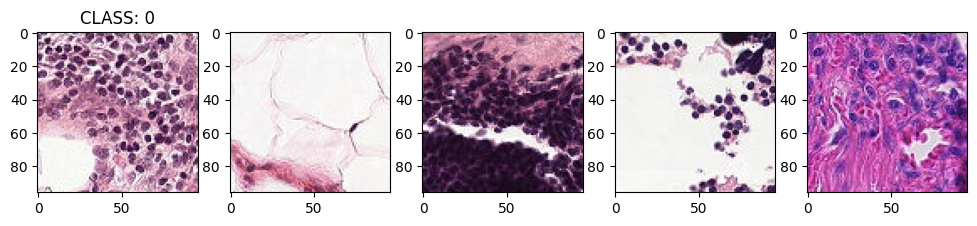

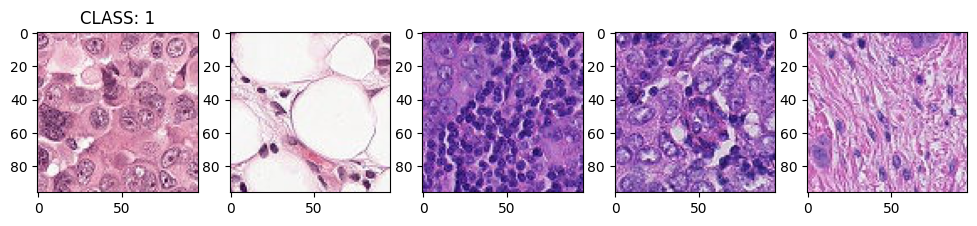

In [ ]:
show_mosaic_id(train_hc,class_h)

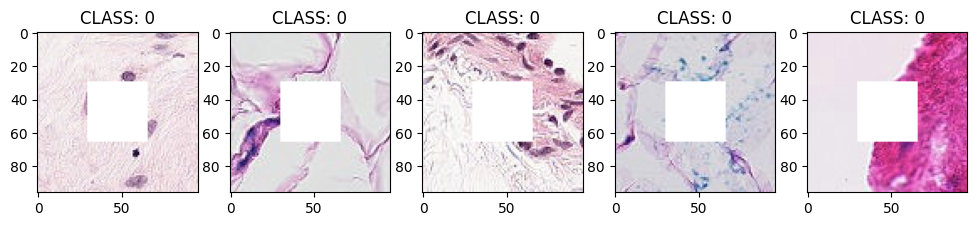

In [6]:
show_mosaic_id_v2(train_hc_central,class_h)

In [ ]:
train_hc.shape, train_hc_central.shape

((5400, 96, 96, 3), (2700, 96, 96, 3))

In [ ]:
x_train,y_train, x_val,y_val, x_test,y_test = train_val_test(train_hc) #,test_size=.25)
x_train_cen,y_train_cen, x_val_cen,y_val_cen, x_test_cen,y_test_cen = train_val_test(train_hc_central,test_size=.01)

x_train = np.r_[x_train,x_train_cen] # Aumentamos los datos de entrenamiento
y_train = np.r_[y_train,y_train_cen]

x_train = norm255_mm_auto(x_train)
x_val  = norm255_mm_auto(x_val)
x_test  = norm255_mm_auto(x_test)
x_train.shape, x_val.shape, x_test.shape



(TensorShape([6102, 96, 96, 3]),
 TensorShape([864, 96, 96, 3]),
 TensorShape([1080, 96, 96, 3]))

#### ***Model-A***:  $~~~3 \times $*`Conv2D`*+ $1\times $*`Dropout(0.5)`*+ $3\times $*`Denses`*

Clasificador Biclase
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 96, 96, 64)        1792      
                                                                 
 Conv2D_4 (Conv2D)           (None, 96, 96, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 1179648)           0         
                                                                 
 densa_1 (Dense)             (None, 120)               141557880 
                                                                 
 densa_2 (Dense)             (None, 24)                2904      
                                                                 
 dropout (Dropout)           (None, 24) 

None


 ::::::----- Inicio de Entrenamiento -----:::::: 

Epoch 1/50
191/191 [==============================] - 37s 111ms/step - loss: 0.7372 - AUC: 0.5022 - PRC: 0.5024 - RECALL: 0.6635 - Error Cuadrático Medio: 0.2531 - Verdadero Positivo: 2019.0000 - Falso Positivo: 1986.0000 - Verdadero Negativo: 1073.0000 - Falso Negativo: 1024.0000 - Accuracy: 0.5067 - Precision: 0.5041 - val_loss: 0.6908 - val_AUC: 0.5947 - val_PRC: 0.5351 - val_RECALL: 0.0047 - val_Error Cuadrático Medio: 0.2488 - val_Verdadero Positivo: 2.0000 - val_Falso Positivo: 1.0000 - val_Verdadero Negativo: 441.0000 - val_Falso Negativo: 420.0000 - val_Accuracy: 0.5127 - val_Precision: 0.6667
Epoch 2/50
191/191 [==============================] - 18s 94ms/step - loss: 0.6938 - AUC: 0.5128 - PRC: 0.5006 - RECALL: 0.7006 - Error Cuadrático Medio: 0.2501 - Verdadero Positivo: 2132.0000 - Falso Positivo: 2074.0000 - Verdadero Negativo: 985.0000 - Falso Negativo: 911.0000 - Accuracy: 0.5108 - Precision: 0.5069 - val_loss: 0.6935 - 

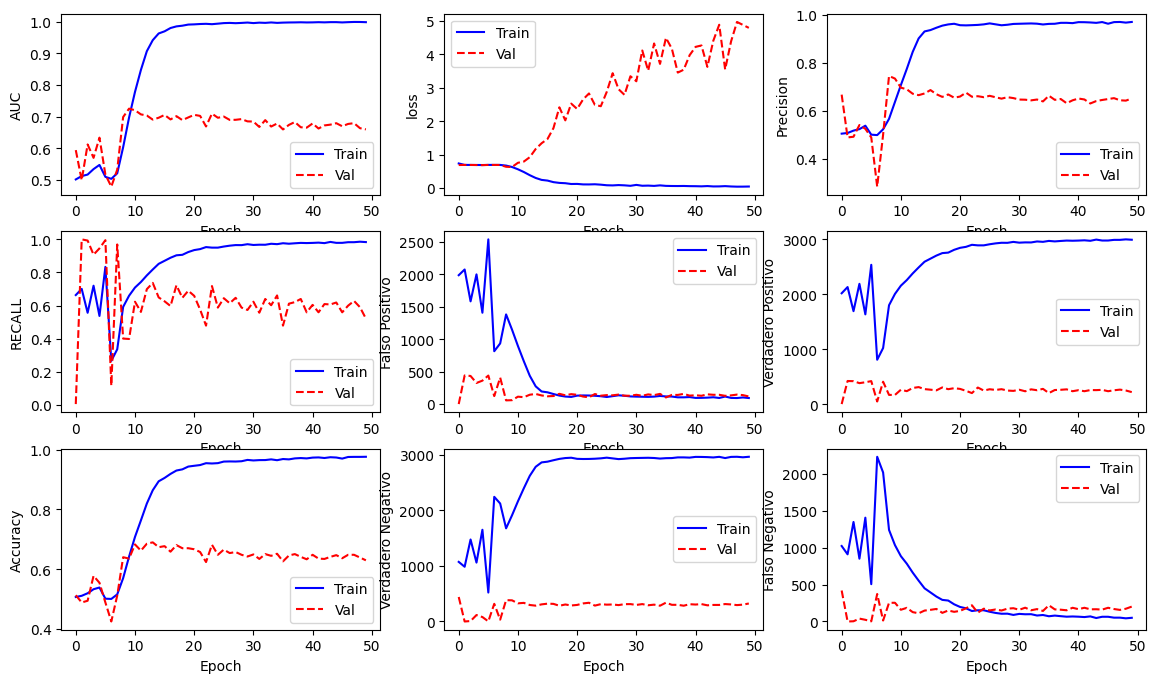

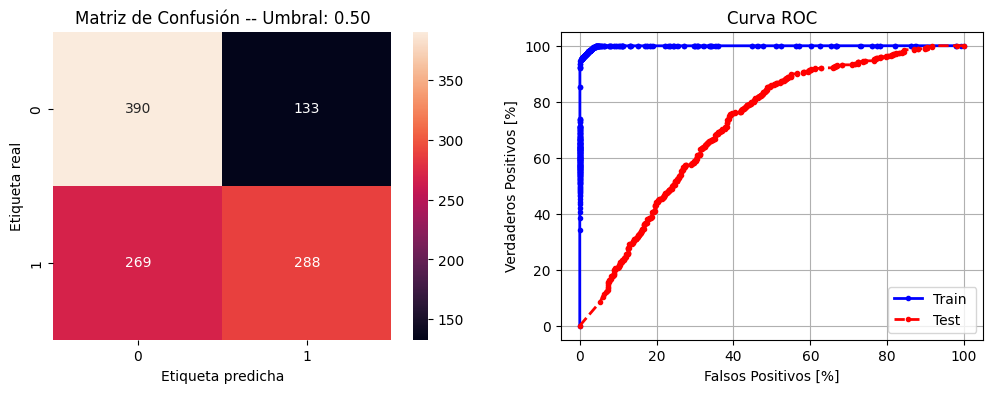

In [ ]:
log_dir="logs/v0/"
batch_size=32
epochs=50

model_name="model_A"
model = model_A(output_bias=bias_0(train_labels,print_desbal = 'no'))  # Inicialización del bias
apply_model_and_metrics(x_train, y_train,x_val, y_val,x_test,y_test,model,epochs,batch_size,model_name,log_dir)

#### ***Model-B***:  $~~~3 \times $*`Conv2D`*+$2\times $*`MaxPooling2D`*+$2\times $*`Dropout(0.5-0.2)`*+$3\times $*`Denses`*

Clasificador Biclase
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 96, 96, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 

None


 ::::::----- Inicio de Entrenamiento -----:::::: 

Epoch 1/50
191/191 [==============================] - 29s 135ms/step - loss: 0.8134 - AUC: 0.5070 - PRC: 0.4983 - RECALL: 0.6339 - Error Cuadrático Medio: 0.2551 - Verdadero Positivo: 1929.0000 - Falso Positivo: 1910.0000 - Verdadero Negativo: 1149.0000 - Falso Negativo: 1114.0000 - Accuracy: 0.5044 - Precision: 0.5025 - val_loss: 0.6905 - val_AUC: 0.5670 - val_PRC: 0.5010 - val_RECALL: 0.0000e+00 - val_Error Cuadrático Medio: 0.2487 - val_Verdadero Positivo: 0.0000e+00 - val_Falso Positivo: 0.0000e+00 - val_Verdadero Negativo: 442.0000 - val_Falso Negativo: 422.0000 - val_Accuracy: 0.5116 - val_Precision: 0.0000e+00
Epoch 2/50
191/191 [==============================] - 23s 122ms/step - loss: 0.6937 - AUC: 0.5027 - PRC: 0.4989 - RECALL: 0.7884 - Error Cuadrático Medio: 0.2503 - Verdadero Positivo: 2399.0000 - Falso Positivo: 2422.0000 - Verdadero Negativo: 637.0000 - Falso Negativo: 644.0000 - Accuracy: 0.4975 - Precision: 0.4976 - va

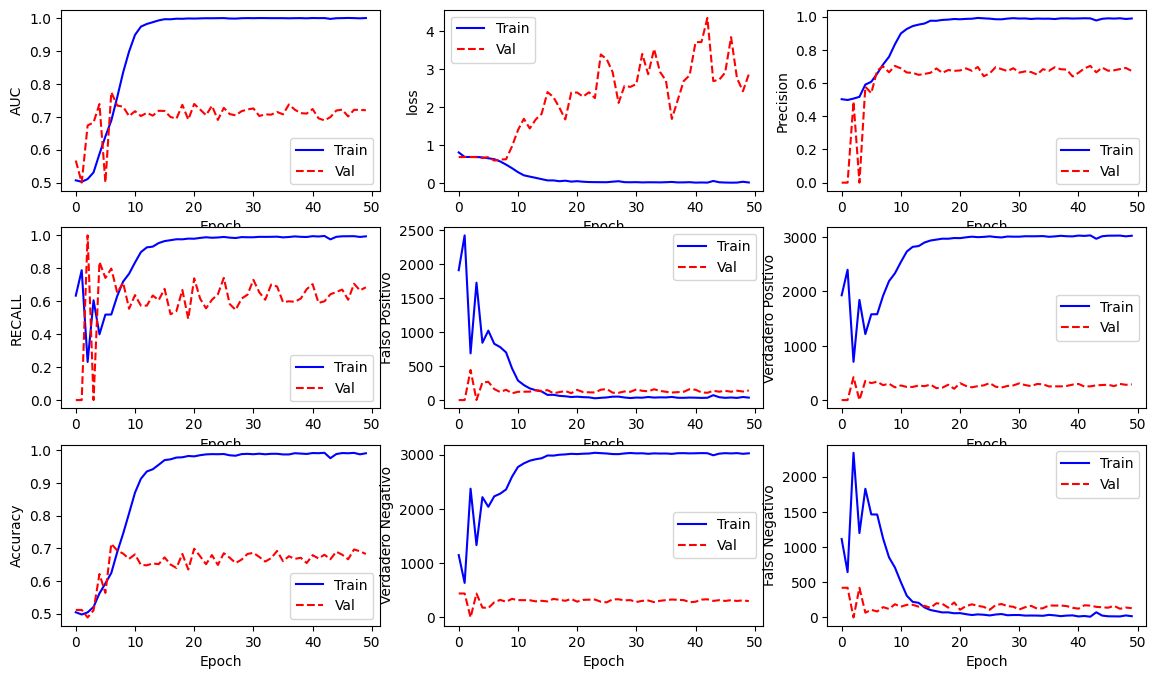

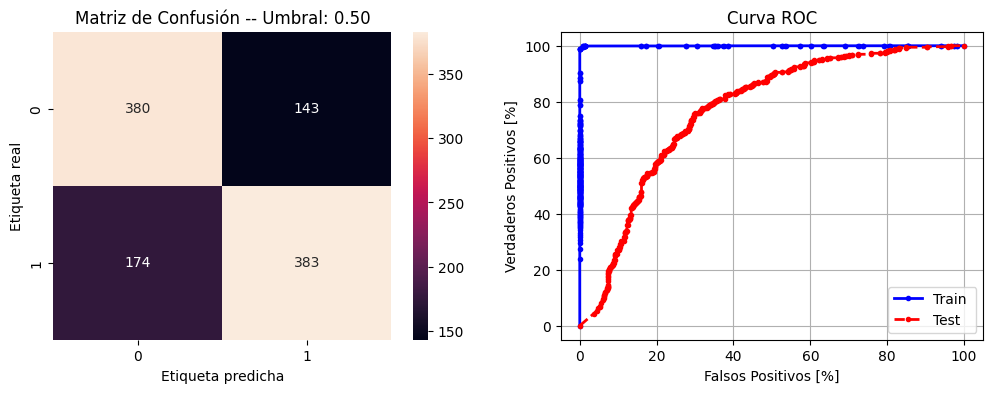

In [ ]:
model_name="model_B"
model = model_B(output_bias=bias_0(train_labels,print_desbal = 'no'))  # Inicialización del bias
apply_model_and_metrics(x_train, y_train,x_val, y_val,x_test,y_test,model,epochs,batch_size,model_name,log_dir)

#### ***Model-C***:  $~~~1 \times $*`Inceptionv-3`*+$1\times $*`GolbalaveragePooling2D`*+$1\times $*`Dropout`*+$3\times $*`Denses`*

Clasificador Biclase
87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
 dense_1 (Dense)             (None, 10)  

None


 ::::::----- Inicio de Entrenamiento -----:::::: 

Epoch 1/50
191/191 [==============================] - 54s 93ms/step - loss: 0.6538 - AUC: 0.6713 - PRC: 0.6873 - RECALL: 0.5573 - Error Cuadrático Medio: 0.2285 - Verdadero Positivo: 1696.0000 - Falso Positivo: 988.0000 - Verdadero Negativo: 2071.0000 - Falso Negativo: 1347.0000 - Accuracy: 0.6173 - Precision: 0.6319 - val_loss: 0.5861 - val_AUC: 0.8054 - val_PRC: 0.8267 - val_RECALL: 0.8886 - val_Error Cuadrático Medio: 0.1983 - val_Verdadero Positivo: 375.0000 - val_Falso Positivo: 260.0000 - val_Verdadero Negativo: 182.0000 - val_Falso Negativo: 47.0000 - val_Accuracy: 0.6447 - val_Precision: 0.5906
Epoch 2/50
191/191 [==============================] - 14s 73ms/step - loss: 0.5931 - AUC: 0.7315 - PRC: 0.7462 - RECALL: 0.6135 - Error Cuadrático Medio: 0.2048 - Verdadero Positivo: 1867.0000 - Falso Positivo: 959.0000 - Verdadero Negativo: 2100.0000 - Falso Negativo: 1176.0000 - Accuracy: 0.6501 - Precision: 0.6607 - val_loss: 0.8839 

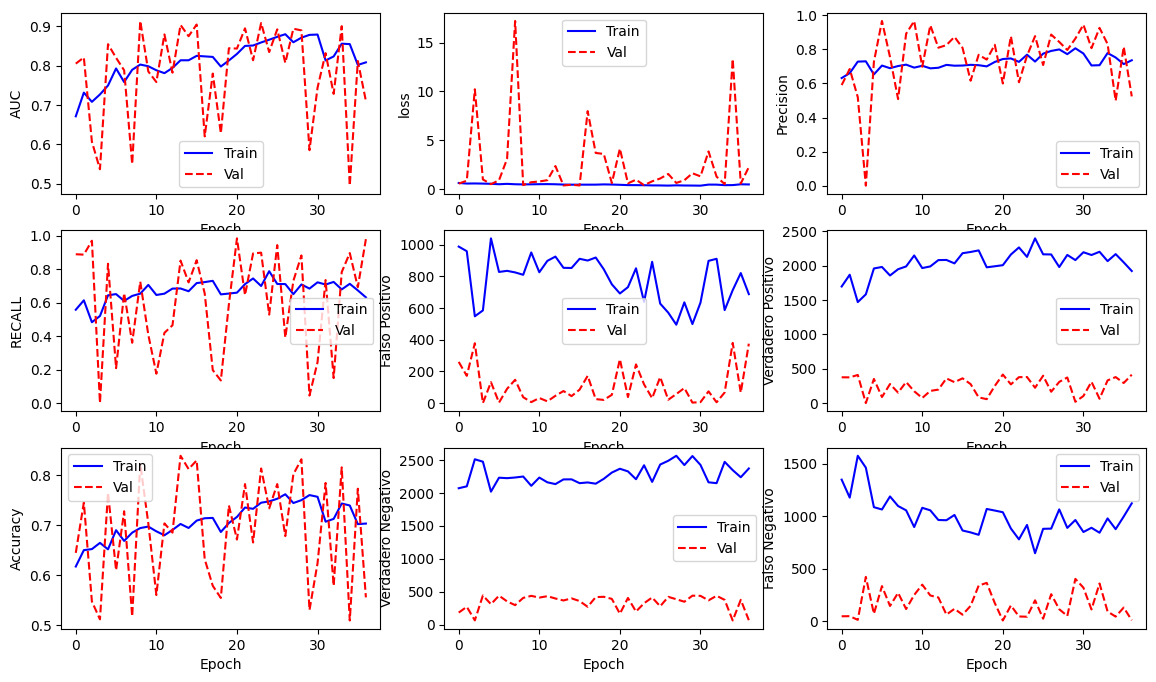

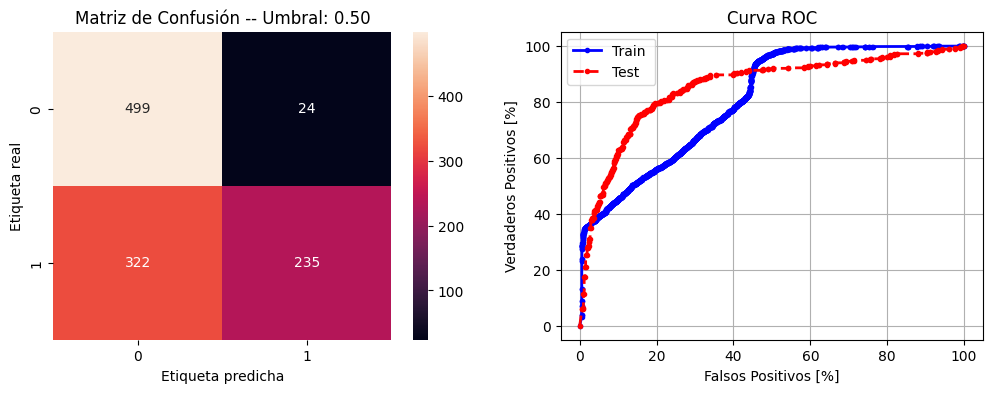

In [ ]:
model_name="model_C"
model = model_C(output_bias=bias_0(train_labels,print_desbal = 'no'))  # Inicialización del bias
apply_model_and_metrics(x_train, y_train,x_val, y_val,x_test,y_test,model,epochs,batch_size,model_name,log_dir)

#### ***Model-D***:  $~~~1 \times $*`ResNet-50`*+$1\times $*`GolbalaveragePooling2D`*+$1\times $*`Dropout`*+$3\times $*`Denses`*

Clasificador Biclase
94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
 dense_1 (Dense)             (None, 10)  

None


 ::::::----- Inicio de Entrenamiento -----:::::: 

Epoch 1/50
191/191 [==============================] - 54s 113ms/step - loss: 0.6165 - AUC: 0.7228 - PRC: 0.7247 - RECALL: 0.6960 - Error Cuadrático Medio: 0.2102 - Verdadero Positivo: 2118.0000 - Falso Positivo: 1234.0000 - Verdadero Negativo: 1825.0000 - Falso Negativo: 925.0000 - Accuracy: 0.6462 - Precision: 0.6319 - val_loss: 0.6936 - val_AUC: 0.5000 - val_PRC: 0.4884 - val_RECALL: 1.0000 - val_Error Cuadrático Medio: 0.2502 - val_Verdadero Positivo: 422.0000 - val_Falso Positivo: 442.0000 - val_Verdadero Negativo: 0.0000e+00 - val_Falso Negativo: 0.0000e+00 - val_Accuracy: 0.4884 - val_Precision: 0.4884
Epoch 2/50
191/191 [==============================] - 19s 97ms/step - loss: 0.5480 - AUC: 0.7747 - PRC: 0.7901 - RECALL: 0.7207 - Error Cuadrático Medio: 0.1871 - Verdadero Positivo: 2193.0000 - Falso Positivo: 1124.0000 - Verdadero Negativo: 1935.0000 - Falso Negativo: 850.0000 - Accuracy: 0.6765 - Precision: 0.6611 - val_loss: 0

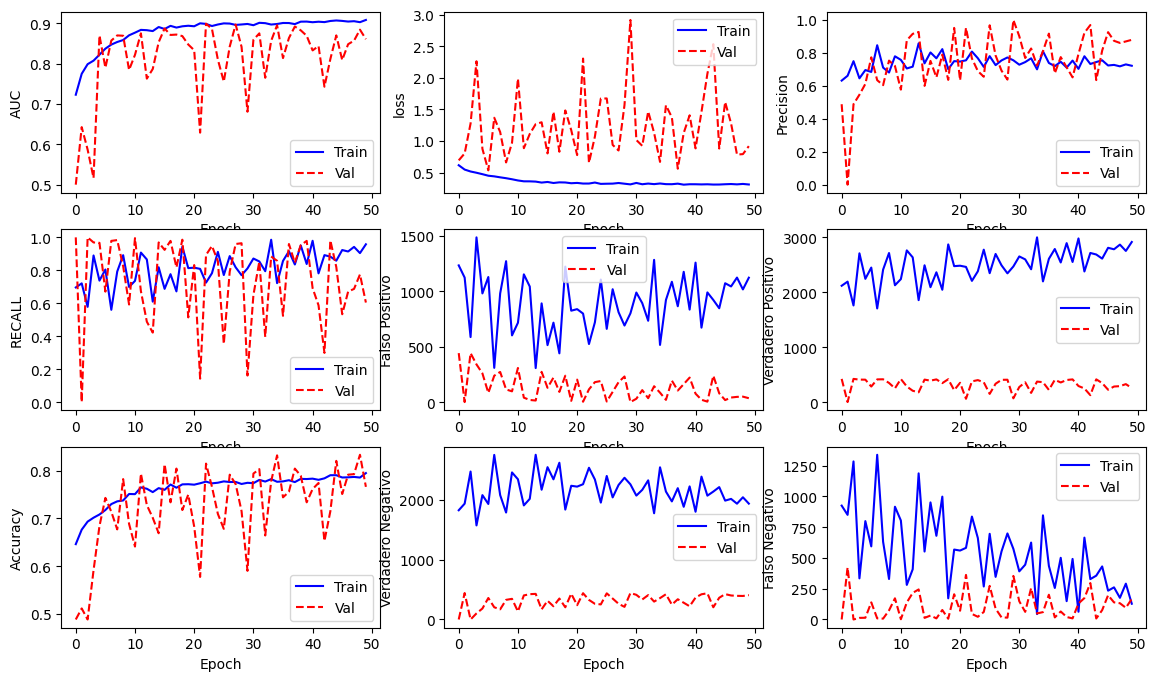

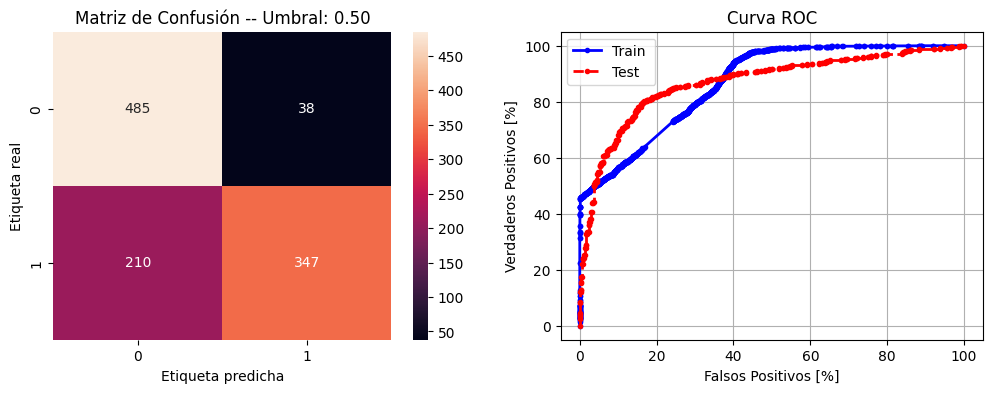

In [ ]:
model_name="model_D"
model = model_D(output_bias=bias_0(train_labels,print_desbal = 'no'))  # Inicialización del bias
apply_model_and_metrics(x_train, y_train,x_val, y_val,x_test,y_test,model,epochs,batch_size,model_name,log_dir)

#### ***Model-E***:  $~~~1 \times $*`Xception`*+$1\times $*`GolbalaveragePooling2D`*+$1\times $*`Dropout`*+$3\times $*`Denses`*

Clasificador Biclase
83683744/83683744 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
 dense_1 (Dense)             (None, 10)  

None


 ::::::----- Inicio de Entrenamiento -----:::::: 

Epoch 1/50
191/191 [==============================] - 49s 127ms/step - loss: 0.6331 - AUC: 0.6799 - PRC: 0.7005 - RECALL: 0.4525 - Error Cuadrático Medio: 0.2200 - Verdadero Positivo: 1377.0000 - Falso Positivo: 637.0000 - Verdadero Negativo: 2422.0000 - Falso Negativo: 1666.0000 - Accuracy: 0.6226 - Precision: 0.6837 - val_loss: 1.3558 - val_AUC: 0.7754 - val_PRC: 0.7785 - val_RECALL: 0.6801 - val_Error Cuadrático Medio: 0.2215 - val_Verdadero Positivo: 287.0000 - val_Falso Positivo: 118.0000 - val_Verdadero Negativo: 324.0000 - val_Falso Negativo: 135.0000 - val_Accuracy: 0.7072 - val_Precision: 0.7086
Epoch 2/50
191/191 [==============================] - 22s 113ms/step - loss: 0.5591 - AUC: 0.7698 - PRC: 0.7763 - RECALL: 0.5922 - Error Cuadrático Medio: 0.1897 - Verdadero Positivo: 1802.0000 - Falso Positivo: 676.0000 - Verdadero Negativo: 2383.0000 - Falso Negativo: 1241.0000 - Accuracy: 0.6858 - Precision: 0.7272 - val_loss: 0.78

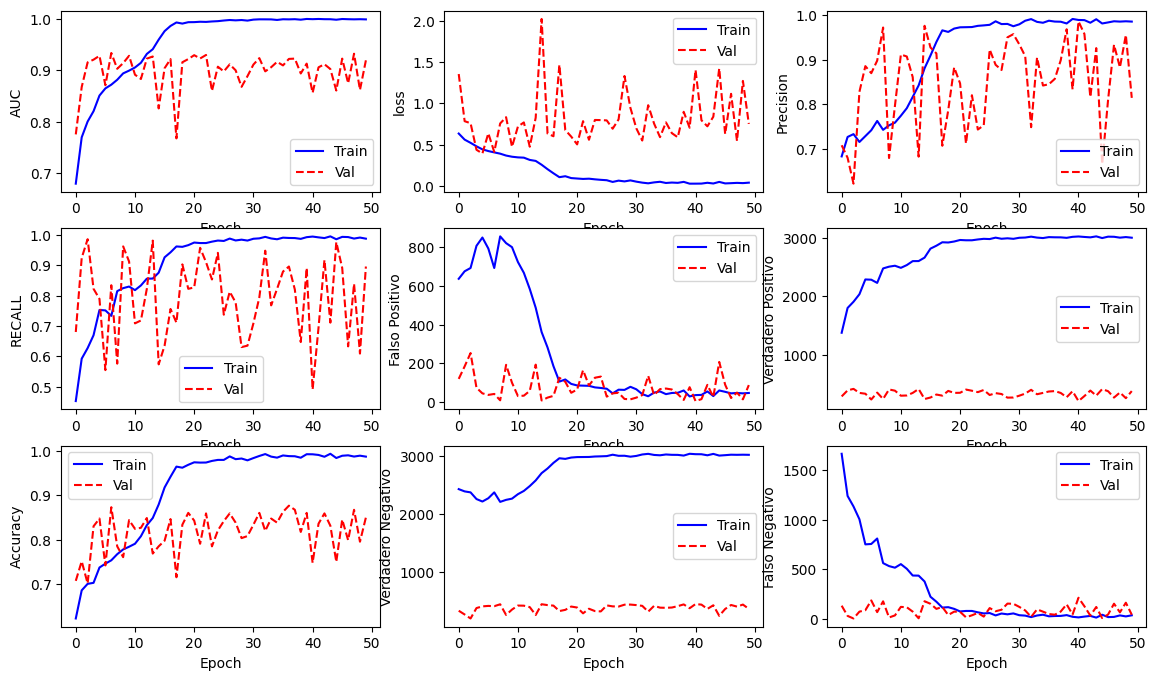

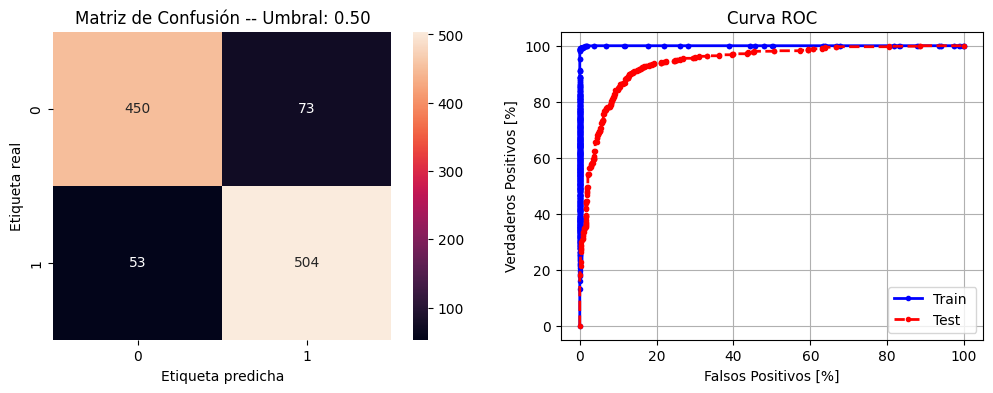

In [ ]:
model_name="model_E"
model = model_E(output_bias=bias_0(train_labels,print_desbal = 'no'))  # Inicialización del bias
apply_model_and_metrics(x_train, y_train,x_val, y_val,x_test,y_test,model,epochs,batch_size,model_name,log_dir)

#### ***Model-F***:  $~~~1 \times $*`ResNet50 + Xception`*+$3\times $*`GolbalaveragePooling2D`*+$1\times $*`Dropout`*+$3\times $*`Denses`*

Clasificador Biclase
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
 dense_1 (Dense)             (None, 10)                1210      
                                        

None


 ::::::----- Inicio de Entrenamiento -----:::::: 

Epoch 1/50
191/191 [==============================] - 45s 120ms/step - loss: 0.5930 - AUC: 0.7391 - PRC: 0.7589 - RECALL: 0.5774 - Error Cuadrático Medio: 0.2035 - Verdadero Positivo: 1757.0000 - Falso Positivo: 735.0000 - Verdadero Negativo: 2324.0000 - Falso Negativo: 1286.0000 - Accuracy: 0.6688 - Precision: 0.7051 - val_loss: 0.8113 - val_AUC: 0.8439 - val_PRC: 0.7947 - val_RECALL: 0.9336 - val_Error Cuadrático Medio: 0.1999 - val_Verdadero Positivo: 394.0000 - val_Falso Positivo: 191.0000 - val_Verdadero Negativo: 251.0000 - val_Falso Negativo: 28.0000 - val_Accuracy: 0.7465 - val_Precision: 0.6735
Epoch 2/50
191/191 [==============================] - 21s 112ms/step - loss: 0.5187 - AUC: 0.8016 - PRC: 0.8153 - RECALL: 0.5951 - Error Cuadrático Medio: 0.1763 - Verdadero Positivo: 1811.0000 - Falso Positivo: 611.0000 - Verdadero Negativo: 2448.0000 - Falso Negativo: 1232.0000 - Accuracy: 0.6980 - Precision: 0.7477 - val_loss: 0.815

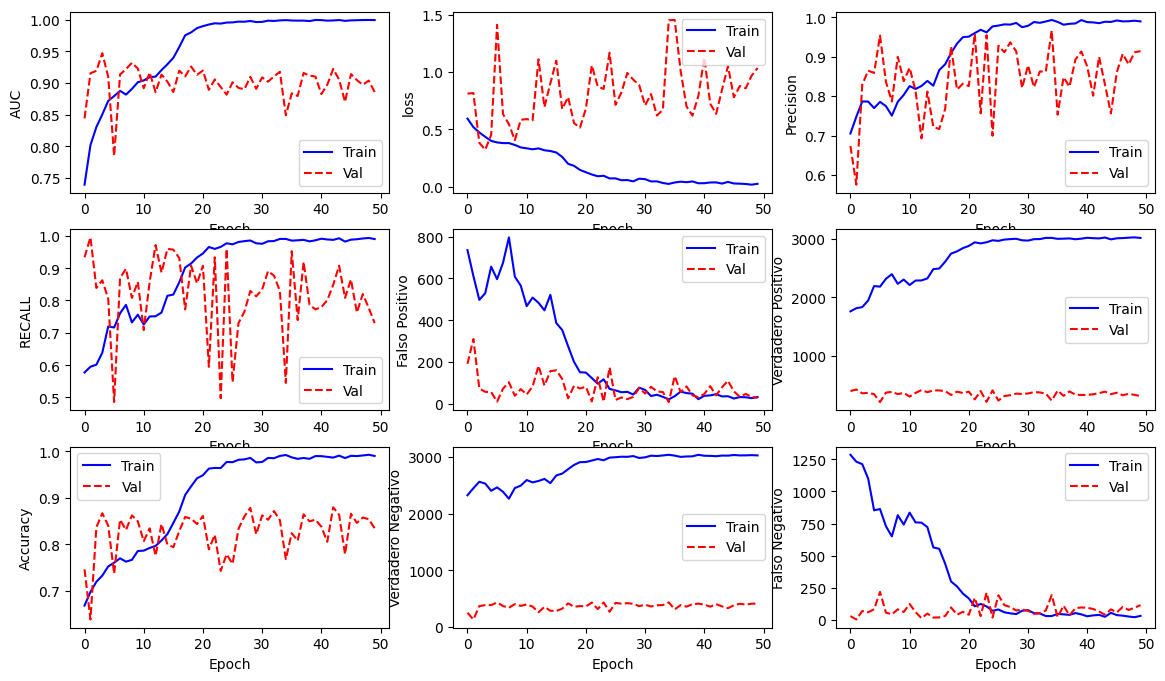

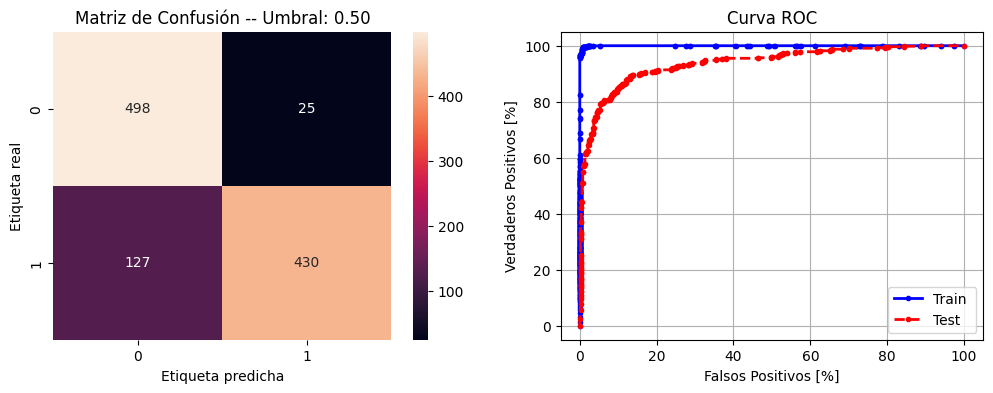

In [ ]:
model_name="model_E"
model = model_E(output_bias=bias_0(train_labels,print_desbal = 'no'))  # Inicialización del bias
apply_model_and_metrics(x_train, y_train,x_val, y_val,x_test,y_test,model,epochs,batch_size,model_name,log_dir)